## Import library

In [1]:
import datetime 
from datetime import timedelta 
import os
import glob
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import roc_curve
from torch import nn, optim

import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from itertools import cycle
from tqdm.notebook import tqdm
import re
from sklearn.metrics import roc_auc_score, plot_roc_curve

import matplotlib.pyplot as plt
import seaborn
from collections import defaultdict

from sklearn import svm

## Data load

In [2]:
base_path = './opendataset'
df_israel_covid = pd.read_csv('israel_sampleddata_20211201.csv')
df_timeseries_confirm = pd.read_csv(f'{base_path}/time_series_covid19_confirmed_global.csv')

/home/md/anaconda3/envs/flu_screening/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df_israel_covid['year_month'] = df_israel_covid['test_date'].apply(lambda x: x[:7])

In [4]:
df_israel_covid.groupby('year_month').count()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
year_month,,,,,,,,,,
2021-12,187544,187544,187544,187544,187544,187544,187544,35493,158739,187544
2022-01,758033,758033,758033,758033,758033,758033,758033,739792,697758,758033
2022-02,252080,252080,252080,252080,252080,252080,252080,228914,212791,252080
2022-03,22224,22224,22224,22224,22224,22224,22224,17209,15232,22224


In [5]:
df_timeseries_confirm.head(5)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288


## preprocessing

In [6]:
# 누적 확진자수를 2021-08-17 와 같은 포멧으로 전처리해주는 과정

rows = []
for idx, values in enumerate(df_timeseries_confirm[df_timeseries_confirm['Country/Region'] == 'Israel'].iteritems()):
    if idx < 4: continue
    year = f"20{values[0][-2:]}"
    month = values[0][:values[0].index('/')]
    month = f'0{month}' if len(month) == 1 else month
    day = values[0][values[0].index('/') + 1 : values[0].rindex('/')]
    day = f'0{day}' if len(day) == 1 else day
    date = f'{year}-{month}-{day}'
    confirmed_num = values[1].item()
    rows.append([date, confirmed_num])
df_numsum_confirmed = pd.DataFrame(rows, columns=['confirmed_date', 'confirmed_numsum'])

In [7]:
# 누적 확진자를 통해 일일 확진자 구하기

df_numsum_confirmed['confirmed_num'] = df_numsum_confirmed['confirmed_numsum'] - df_numsum_confirmed.shift(1)['confirmed_numsum']
df_numsum_confirmed = df_numsum_confirmed.dropna()
df_numsum_confirmed['confirmed_num'] = df_numsum_confirmed['confirmed_num'].astype(int)

In [8]:
# 일일 확진자수가 음수인 경우 그 전날 확진자를 가져다 쓰는 과정

for idx, row in df_numsum_confirmed[df_numsum_confirmed['confirmed_num'] < 0].iterrows():
    print("before", df_numsum_confirmed.loc[idx,'confirmed_num'])
    df_numsum_confirmed.loc[idx,'confirmed_num'] = df_numsum_confirmed.loc[idx-1,'confirmed_num']
    print("after", df_numsum_confirmed.loc[idx,'confirmed_num'])
    print()

before -28
after 28

before -53
after 34

before -1149
after 701



In [9]:
def filter_date(date):
    year = f"20{date[-2:]}"
    month = date[:date.index('/')]
    month = f'0{month}' if len(month) == 1 else month
    day = date[date.index('/') + 1 : date.rindex('/')]
    day = f'0{day}' if len(day) == 1 else day
    res = f'{year}-{month}-{day}'
    return res

In [10]:
def _get_global_confirmed_df(df_timeseries_confirm):
    df_confirmed_global = df_timeseries_confirm.sum().reset_index()
    df_confirmed_global = df_confirmed_global.rename(columns={'index': 'global_confirmed_date', 0: 'global_confirmed_numsum'}).iloc[3:, :]
    df_confirmed_global = df_confirmed_global.reset_index(drop=True)
    df_confirmed_global['global_confirmed_num'] = df_confirmed_global['global_confirmed_numsum'] - df_confirmed_global.shift(1)['global_confirmed_numsum']
    df_confirmed_global = df_confirmed_global.dropna()
    df_confirmed_global['global_confirmed_num'] = df_confirmed_global['global_confirmed_num'].astype(int)
    df_confirmed_global['global_confirmed_date'] = df_confirmed_global['global_confirmed_date'].apply(filter_date)
    return df_confirmed_global

In [11]:
def get_global_confirmed_df():
    url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
    df_timeseries_confirm = pd.read_csv(url)
#     display(df_timeseries_confirm)
    global_confirmed_df = _get_global_confirmed_df(df_timeseries_confirm)
    return global_confirmed_df

In [12]:
GLOBAL_CONFIRMED_MAX = 78.88 * 100000000

In [13]:
global_confirmed_df = get_global_confirmed_df()

In [14]:
global_confirmed_df['global_confirmed_ratio'] = global_confirmed_df['global_confirmed_num'] / GLOBAL_CONFIRMED_MAX

In [15]:
df_numsum_confirmed.tail(5)

,confirmed_date,confirmed_numsum,confirmed_num
1138,2023-03-05,4801502,281
1139,2023-03-06,4801502,0
1140,2023-03-07,4801502,0
1141,2023-03-08,4803164,1662
1142,2023-03-09,4803824,660


In [16]:
df_israel_covid = df_israel_covid.sort_values('test_date')
df_israel_covid.head(5)

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication,year_month
1219880,2021-12-01,0,0,0,0,0,שלילי,NaN,נקבה,Other,2021-12
1215978,2021-12-01,0,0,0,0,0,שלילי,NaN,נקבה,Other,2021-12
1215979,2021-12-01,0,0,0,0,0,שלילי,NaN,זכר,Other,2021-12
1215980,2021-12-01,0,0,0,0,0,שלילי,NaN,זכר,Other,2021-12
1215981,2021-12-01,0,0,0,0,0,שלילי,NaN,זכר,Other,2021-12


In [17]:
# 기존 이스라엘 데이터에 일일 확진자랑 일일 누적 확진자 컬럼을 넣어주는 과정

df_israel_covid = pd.merge(df_israel_covid, df_numsum_confirmed, how='left', left_on='test_date', right_on='confirmed_date')

In [18]:
df_israel_covid.shape[0]

1219881

In [19]:
head_ne = df_israel_covid[df_israel_covid['head_ache'] == 0]
head_po = df_israel_covid[df_israel_covid['head_ache'] == 1]
print(head_ne.shape[0]+head_po.shape[0])

1219881


## 번역하기

In [20]:
def gender_map(gender):
    if gender == 'נקבה': return 1 #'Female'
    elif gender == 'זכר': return 0 #'Male'
    return -1

In [21]:
def corona_result_map(corona_result):
    if corona_result == 'אחר': return -1 # 'Other'
    elif corona_result == 'שלילי': return 0 # 'Negative'
    elif corona_result == 'חיובי': return 1 # 'Positive'
    return ''

In [22]:
def age_60_and_above_map(age_60_and_above):
    if age_60_and_above == 'Yes': return 1
    elif age_60_and_above == 'No': return 0
    return -1

In [23]:
def test_indication_map(test_indication):
    if test_indication == 'Other': return 0
    elif test_indication == 'Abroad': return 1
    elif  test_indication == 'Contact with confirmed': return 2
    else: return -1

In [24]:
df_israel_covid['gender'] = df_israel_covid['gender'].apply(gender_map)
df_israel_covid['corona_result'] = df_israel_covid['corona_result'].apply(corona_result_map)
df_israel_covid['age_60_and_above'] = df_israel_covid['age_60_and_above'].apply(age_60_and_above_map)
df_israel_covid['test_indication'] = df_israel_covid['test_indication'].apply(test_indication_map)

In [25]:
df_israel_covid['indication_other'] = df_israel_covid['test_indication'].apply(lambda x : 1 if x == 0 else 0)
df_israel_covid['indication_abroad'] = df_israel_covid['test_indication'].apply(lambda x : 1 if x == 1 else 0)
df_israel_covid['indication_contact'] = df_israel_covid['test_indication'].apply(lambda x : 1 if x == 2 else 0)

## model input preprocessing

In [26]:
# other 빼버림
df_israel_covid_without_o = df_israel_covid[df_israel_covid['corona_result'] != -1]

In [27]:
df_israel_covid_without_o.shape[0]

1175160

In [28]:
# 성별 없는 사람들 빼버림
df_israel_covid_without_o = df_israel_covid_without_o[df_israel_covid_without_o['gender'] != -1]
df_israel_covid_without_o = df_israel_covid_without_o[df_israel_covid_without_o['age_60_and_above'] != -1]

In [29]:
df_israel_covid_without_o.shape[0]

897131

In [30]:
df_israel_covid_without_o = df_israel_covid_without_o.sort_values(['test_date']).reset_index(drop=True)

In [31]:
df_israel_covid_without_o['test_date'].min()

'2021-12-28'

In [32]:
def random_sampling(df, lower_year_month, upper_year_month):
    df_sampled = pd.DataFrame([], columns=df.columns)
    for year_month, df_by_ym in df.groupby('year_month'):
        if year_month < lower_year_month or year_month > upper_year_month: continue
        num = df_by_ym.shape[0] if df_by_ym.shape[0] <= 100000 else 100000
        df_sampled = pd.concat([df_sampled, df_by_ym.sample(n=num, random_state=1)])
    return df_sampled

In [33]:
df_israel_covid_without_o

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication,year_month,confirmed_date,confirmed_numsum,confirmed_num,indication_other,indication_abroad,indication_contact
0,2021-12-28,0,0,0,0,0,0,0,0,0,2021-12,2021-12-28,1371000,2995,1,0,0
1,2021-12-28,0,0,0,0,0,0,0,1,0,2021-12,2021-12-28,1371000,2995,1,0,0
2,2021-12-28,0,0,0,0,0,0,0,1,0,2021-12,2021-12-28,1371000,2995,1,0,0
3,2021-12-28,0,0,0,0,0,0,0,1,0,2021-12,2021-12-28,1371000,2995,1,0,0
4,2021-12-28,0,0,0,0,0,0,0,1,0,2021-12,2021-12-28,1371000,2995,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897126,2022-03-03,0,0,0,0,0,1,0,0,0,2022-03,2022-03-03,3653601,2377,1,0,0
897127,2022-03-03,0,0,0,0,0,1,0,0,0,2022-03,2022-03-03,3653601,2377,1,0,0
897128,2022-03-03,0,0,0,0,0,1,0,0,0,2022-03,2022-03-03,3653601,2377,1,0,0
897129,2022-03-03,0,0,0,0,0,0,0,1,0,2022-03,2022-03-03,3653601,2377,1,0,0


In [34]:
ISRAEL_CONFIRMED_MAX = 9360000
KOREA_CONFIRMED_MAX = 51740000
GLOBAL_CONFIRMED_MAX = 78.88 * 100000000

In [35]:
df_israel_covid_without_o['confirmed_ratio'] = df_israel_covid_without_o['confirmed_num'] / ISRAEL_CONFIRMED_MAX

In [36]:
df_israel_covid_without_o = pd.merge(df_israel_covid_without_o, global_confirmed_df, how='left', left_on='test_date', right_on='global_confirmed_date')

In [37]:
df_israel_covid_without_o.columns

Index(['test_date', 'cough', 'fever', 'sore_throat', 'shortness_of_breath',
       'head_ache', 'corona_result', 'age_60_and_above', 'gender',
       'test_indication', 'year_month', 'confirmed_date', 'confirmed_numsum',
       'confirmed_num', 'indication_other', 'indication_abroad',
       'indication_contact', 'confirmed_ratio', 'global_confirmed_date',
       'global_confirmed_numsum', 'global_confirmed_num',
       'global_confirmed_ratio'],
      dtype='object')

In [38]:
df_train = random_sampling(df_israel_covid_without_o, '2021-12', '2022-01')
df_test = random_sampling(df_israel_covid_without_o, '2022-02', '2022-03')

In [39]:
df_train.shape, df_test.shape

((130872, 22), (112266, 22))

In [40]:
df_train = df_train.apply(pd.to_numeric, errors='coerce')
df_test = df_test.apply(pd.to_numeric, errors='coerce')

In [41]:
df_train.groupby('corona_result').size()

corona_result
0    89123
1    41749
dtype: int64

In [42]:
df_test.groupby('corona_result').size()

corona_result
0    56328
1    55938
dtype: int64

In [43]:
df_train.columns

Index(['test_date', 'cough', 'fever', 'sore_throat', 'shortness_of_breath',
       'head_ache', 'corona_result', 'age_60_and_above', 'gender',
       'test_indication', 'year_month', 'confirmed_date', 'confirmed_numsum',
       'confirmed_num', 'indication_other', 'indication_abroad',
       'indication_contact', 'confirmed_ratio', 'global_confirmed_date',
       'global_confirmed_numsum', 'global_confirmed_num',
       'global_confirmed_ratio'],
      dtype='object')

In [44]:
# 여기서 내가 사용할 feature 고르기
# age_60_and_above', 'gender', 'confirmed_ratio', 
col1 = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']
col2 = ['age_60_and_above', 'gender']
col3 = ['indication_other', 'indication_abroad', 'indication_contact']
col4 = ['confirmed_ratio']
col5 = ['global_confirmed_ratio']

input_cols = col1 + col2 + col3 + col4 + col5
input_cols.append('corona_result')

raw_train_datas = df_train[input_cols].values
raw_test_datas = df_test[input_cols].values

In [45]:
train_input = raw_train_datas[:, :-1]
train_gt = raw_train_datas[:, -1]

In [46]:
test_input = raw_train_datas[:, :-1]
test_gt = raw_train_datas[:, -1]

In [53]:
def display_performance(clf, pred, valid_input, valid_gt, auc):
    pred = np.array(pred)
    print('accuracy %.4f' % (accuracy_score(pred, valid_gt)))
    print('precision %.4f' % (precision_score(pred, valid_gt)))
    print('recall %.4f' % (recall_score(pred, valid_gt)))
    print('f1-score %.4f' % (f1_score(pred, valid_gt)))
    print('auc-score %.4f' % (auc))
    print(confusion_matrix(valid_gt, pred))
    
    
    plot_roc_curve(clf, valid_input, valid_gt)

In [54]:
df_train[input_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130872 entries, 20148 to 107218
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   cough                   130872 non-null  int64  
 1   fever                   130872 non-null  int64  
 2   sore_throat             130872 non-null  int64  
 3   shortness_of_breath     130872 non-null  int64  
 4   head_ache               130872 non-null  int64  
 5   age_60_and_above        130872 non-null  int64  
 6   gender                  130872 non-null  int64  
 7   indication_other        130872 non-null  int64  
 8   indication_abroad       130872 non-null  int64  
 9   indication_contact      130872 non-null  int64  
 10  confirmed_ratio         130872 non-null  float64
 11  global_confirmed_ratio  130872 non-null  float64
 12  corona_result           130872 non-null  int64  
dtypes: float64(2), int64(11)
memory usage: 14.0 MB


In [55]:
for col in input_cols:
    print(col)
    display(df_train[col].value_counts())

cough


0    127387
1      3485
Name: cough, dtype: int64

fever


0    129189
1      1683
Name: fever, dtype: int64

sore_throat


0    129287
1      1585
Name: sore_throat, dtype: int64

shortness_of_breath


0    130729
1       143
Name: shortness_of_breath, dtype: int64

head_ache


0    128868
1      2004
Name: head_ache, dtype: int64

age_60_and_above


0    107717
1     23155
Name: age_60_and_above, dtype: int64

gender


1    68062
0    62810
Name: gender, dtype: int64

indication_other


1    125679
0      5193
Name: indication_other, dtype: int64

indication_abroad


0    130168
1       704
Name: indication_abroad, dtype: int64

indication_contact


0    126383
1      4489
Name: indication_contact, dtype: int64

confirmed_ratio


0.000000    14880
0.000598     8363
0.000368     8363
0.000415     7497
0.000320     6649
0.001977     5302
0.003366     4760
0.008603     4593
0.002765     4577
0.001869     4374
0.025993     4349
0.005824     4136
0.007320     3962
0.001841     3492
0.022675     3383
0.004763     3377
0.002075     3295
0.002508     3129
0.006845     3060
0.005838     2953
0.007599     2716
0.008616     2665
0.001575     2419
0.002393     2407
0.007523     2287
0.010041     2254
0.000735     2087
0.001047     1950
0.006439     1922
0.000541     1808
0.004848     1649
0.005762     1404
0.000654      810
Name: confirmed_ratio, dtype: int64

global_confirmed_ratio


0.000216    8363
0.000247    8363
0.000216    7497
0.000169    6649
0.000275    5302
0.000352    5165
0.000477    4968
0.000384    4760
0.000302    4747
0.000437    4593
0.000404    4577
0.000254    4374
0.000518    4349
0.000412    4136
0.000473    3962
0.000328    3492
0.000461    3383
0.000336    3377
0.000338    3295
0.000420    3129
0.000483    3060
0.000308    2953
0.000276    2716
0.000463    2665
0.000374    2419
0.000271    2407
0.000489    2287
0.000477    2254
0.000331    2087
0.000296    1950
0.000469    1922
0.000116    1808
0.000466    1649
0.000325    1404
0.000153     810
Name: global_confirmed_ratio, dtype: int64

corona_result


0    89123
1    41749
Name: corona_result, dtype: int64

In [56]:
# for col in input_cols:
#     print(col)
#     display(df_shine[col].value_counts())

In [57]:
train_input.shape, train_gt.shape

((130872, 12), (130872,))

In [58]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

logistic_clf = LogisticRegression(C=1000.0, random_state=0)
logistic_clf = logistic_clf.fit(train_input, train_gt)

/home/md/anaconda3/envs/flu_screening/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### confusion matrix
- TN FP
- FN TP

accuracy 0.6967
precision 0.1779
recall 0.5801
f1-score 0.2723
auc-score 0.7015
[[83748  5375]
 [34322  7427]]


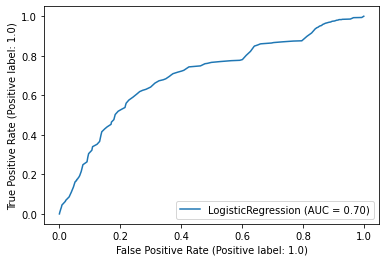

In [60]:
pred = logistic_clf.predict(test_input)
auc = roc_auc_score(test_gt, logistic_clf.predict_proba(test_input)[:,1])
display_performance(logistic_clf, pred, test_input, test_gt, auc)

In [61]:
# from sklearn.ensemble import GradientBoostingClassifier
# gb_clf = GradientBoostingClassifier(random_state=0)
# gb_clf.fit(train_input, train_gt)

In [62]:
df_shine = pd.read_csv('../shine_model_update/ktplatform_data_20230324.csv')

In [63]:
df_shine.shape

(15376, 52)

In [64]:
df_shine['confirmed_ratio'] = df_shine['confirmed_num'] / KOREA_CONFIRMED_MAX
df_shine['global_confirmed_ratio'] = df_shine['global_confirmed_num'] / GLOBAL_CONFIRMED_MAX

In [65]:
df_shine.columns

Index(['Unnamed: 0', 'patient_id', 'gender', 'age', 'birthday',
       'age_60_and_above', 'fever', 'sx_name', 'etc_status', 'is_abroad',
       'is_visit', 'is_contact', 'is_isolation', 'selfcheck_reason',
       'selfcheck_date', 'pcr_date', 'pcr_place', 'sido', 'sigungu',
       'pcr_result', 'cough', 'sore_throat', 'shortness_of_breath',
       'head_ache', 'runny_nose', 'muscle_pain', 'chills', 'loss_of_taste',
       'loss_of_smell', 'sputum', 'chest_pain', 'indication_other',
       'indication_abroad', 'indication_contact', 'weekday', 'age_ratio',
       'confirmed_date', 'confirmed_numsum', 'confirmed_num',
       'confirmed_week_num', 'confirmed_ratio', 'confirmed_week_ratio',
       'global_confirmed_date', 'global_confirmed_numsum',
       'global_confirmed_num', 'global_confirmed_week_num',
       'global_confirmed_ratio', 'global_confirmed_week_ratio', '_id',
       'confirmed_total', 'sigungu_confirmed_ratio', 'mask'],
      dtype='object')

In [66]:
df_shine = df_shine.rename(columns={'pcr_result': 'corona_result'})
# df_shine['corona_result'] = df_shine['corona_result'].apply(lambda x: x-1)

In [67]:
df_shine['year_month'] = df_shine['pcr_date'].apply(lambda x : x[:7])

In [68]:
df_shine.groupby('year_month').size()

year_month
2021-10      19
2021-11      60
2021-12     104
2022-01     136
2022-02     695
2022-03    7351
2022-04    2959
2022-05     617
2022-06     309
2022-07     398
2022-08     735
2022-09     414
2022-10     293
2022-11     407
2022-12     442
2023-01     224
2023-02     172
2023-03      41
dtype: int64

In [69]:
df_shine = df_shine[df_shine['year_month'] >= '2022-02']
df_shine = df_shine[df_shine['year_month'] < '2023-03']

In [70]:
df_shine['age_60_and_above'] = df_shine['age_60_and_above'].astype(int)
df_shine['gender'] = df_shine['gender'].astype(int)

In [71]:
df_shine['pcr_date'].min(), df_shine['pcr_date'].max()

('2022-02-01', '2023-02-28')

In [72]:
df_shine.groupby('corona_result').size()

corona_result
0     4755
1    10261
dtype: int64

In [73]:
df_shine[input_cols].info(), df_train[input_cols].info(), df_test[input_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15016 entries, 319 to 15334
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cough                   15016 non-null  int64  
 1   fever                   15016 non-null  int64  
 2   sore_throat             15016 non-null  int64  
 3   shortness_of_breath     15016 non-null  int64  
 4   head_ache               15016 non-null  int64  
 5   age_60_and_above        15016 non-null  int64  
 6   gender                  15016 non-null  int64  
 7   indication_other        15016 non-null  int64  
 8   indication_abroad       15016 non-null  int64  
 9   indication_contact      15016 non-null  int64  
 10  confirmed_ratio         15016 non-null  float64
 11  global_confirmed_ratio  15016 non-null  float64
 12  corona_result           15016 non-null  int64  
dtypes: float64(2), int64(11)
memory usage: 1.6 MB
<class 'pandas.core.frame.DataFrame'>
Int64

(None, None, None)

accuracy 0.8141
precision 0.8491
recall 0.8751
f1-score 0.8619
auc-score 0.8603
[[3511 1244]
 [1548 8713]]


Text(0.5, 1.0, '# of data: 15016, # of pos: 10261.0, # of neg: 4755.0, auc: 0.86026')

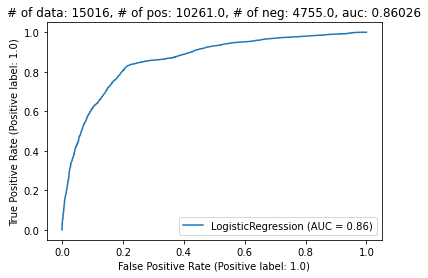

In [74]:
raw_shine_test_datas = df_shine[input_cols].values
shine_test_input = raw_shine_test_datas[:, :-1]
shine_test_gt = raw_shine_test_datas[:, -1]
size = shine_test_input.shape[0]
pos_cnt = shine_test_gt.sum()
neg_cnt = len(shine_test_gt) - pos_cnt
pred = logistic_clf.predict(shine_test_input)
auc = roc_auc_score(shine_test_gt, logistic_clf.predict_proba(shine_test_input)[:,1])
display_performance(logistic_clf, pred, shine_test_input, shine_test_gt, auc)
plt.title(f'# of data: {size}, # of pos: {pos_cnt}, # of neg: {neg_cnt}, auc: {auc:.5f}')

In [75]:
df_shine_list = []
month_df_count_sum = 0
for year_month, df in df_shine.groupby('year_month'):
    month_df_count_sum += df.shape[0]
    df_shine_list.append(df)

In [76]:
month_df_count_sum, df_shine.shape[0]

(15016, 15016)

In [77]:
def balanced_random_sampling(df):
    df_neg = df[df['corona_result'] == 0]
    df_pos = df[df['corona_result'] == 1]
    
    pos_n = 40
    if df_pos.shape[0] < pos_n:
        pos_n = df_pos.shape[0]
    neg_n = 100 - pos_n
        
    row = []
    rs = 1
    while rs <= 10000:
        print(df_neg.shape)
        df_neg_sampled = df_neg.sample(n=neg_n, random_state=rs)
        df_pos_sampled = df_pos.sample(n=pos_n, random_state=rs)
        df_row = pd.concat([df_neg_sampled, df_pos_sampled], axis=0)
        print(f"{df_neg_sampled.shape}, {df_pos_sampled.shape}, {df_row.shape}")
        row.append(df_row)
        rs *= 10
    return row

In [78]:
raw_shine_test_datas_list = []
for df_shine in df_shine_list:
    row = []
    year_month = df_shine['year_month'].iloc[0]
    row.append(year_month)
    row.append(df_shine.shape[0])
    row.append([i.values for i in balanced_random_sampling(df_shine[input_cols])])
    raw_shine_test_datas_list.append(row)

(259, 13)
(60, 13), (40, 13), (100, 13)
(259, 13)
(60, 13), (40, 13), (100, 13)
(259, 13)
(60, 13), (40, 13), (100, 13)
(259, 13)
(60, 13), (40, 13), (100, 13)
(259, 13)
(60, 13), (40, 13), (100, 13)
(1102, 13)
(60, 13), (40, 13), (100, 13)
(1102, 13)
(60, 13), (40, 13), (100, 13)
(1102, 13)
(60, 13), (40, 13), (100, 13)
(1102, 13)
(60, 13), (40, 13), (100, 13)
(1102, 13)
(60, 13), (40, 13), (100, 13)
(846, 13)
(60, 13), (40, 13), (100, 13)
(846, 13)
(60, 13), (40, 13), (100, 13)
(846, 13)
(60, 13), (40, 13), (100, 13)
(846, 13)
(60, 13), (40, 13), (100, 13)
(846, 13)
(60, 13), (40, 13), (100, 13)
(469, 13)
(60, 13), (40, 13), (100, 13)
(469, 13)
(60, 13), (40, 13), (100, 13)
(469, 13)
(60, 13), (40, 13), (100, 13)
(469, 13)
(60, 13), (40, 13), (100, 13)
(469, 13)
(60, 13), (40, 13), (100, 13)
(265, 13)
(60, 13), (40, 13), (100, 13)
(265, 13)
(60, 13), (40, 13), (100, 13)
(265, 13)
(60, 13), (40, 13), (100, 13)
(265, 13)
(60, 13), (40, 13), (100, 13)
(265, 13)
(60, 13), (40, 13), (100,

In [79]:
# sz_sum = 0

# for year_month, size, raw_shine_test_datas in raw_shine_test_datas_list:
#     shine_test_input = raw_shine_test_datas[:, :-1]
#     shine_test_gt = raw_shine_test_datas[:, -1]
#     pos_cnt = shine_test_gt.sum()
#     neg_cnt = len(shine_test_gt) - pos_cnt
#     sz_sum += size
#     print(f'{size}')
    
# sz_sum

### 100개 random sampling

date: 2022-02
accuracy 0.7400
precision 0.8750
recall 0.6250
f1-score 0.7292
auc-score 0.8125
[[39 21]
 [ 5 35]]
accuracy 0.7200
precision 0.8000
recall 0.6154
f1-score 0.6957
auc-score 0.7677
[[40 20]
 [ 8 32]]
accuracy 0.7600
precision 0.9250
recall 0.6379
f1-score 0.7551
auc-score 0.8246
[[39 21]
 [ 3 37]]
accuracy 0.7100
precision 0.8250
recall 0.6000
f1-score 0.6947
auc-score 0.7950
[[38 22]
 [ 7 33]]
accuracy 0.7500
precision 0.9500
recall 0.6230
f1-score 0.7525
auc-score 0.7902
[[37 23]
 [ 2 38]]
date: 2022-03
accuracy 0.6700
precision 0.9000
recall 0.5538
f1-score 0.6857
auc-score 0.7538
[[31 29]
 [ 4 36]]
accuracy 0.6700
precision 0.9000
recall 0.5538
f1-score 0.6857
auc-score 0.7194
[[31 29]
 [ 4 36]]
accuracy 0.7200
precision 0.9500
recall 0.5938
f1-score 0.7308
auc-score 0.8267
[[34 26]
 [ 2 38]]
accuracy 0.7000
precision 0.8750
recall 0.5833
f1-score 0.7000
auc-score 0.8150
[[35 25]
 [ 5 35]]
accuracy 0.7600
precision 0.9250
recall 0.6379
f1-score 0.7551
auc-score 0.8681
[

/home/md/anaconda3/envs/flu_screening/lib/python3.8/site-packages/sklearn/metrics/_plot/roc_curve.py:117: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


accuracy 0.7900
precision 0.5750
recall 0.8519
f1-score 0.6866
auc-score 0.8190
[[56  4]
 [17 23]]
accuracy 0.8200
precision 0.6250
recall 0.8929
f1-score 0.7353
auc-score 0.8681
[[57  3]
 [15 25]]
accuracy 0.7900
precision 0.6000
recall 0.8276
f1-score 0.6957
auc-score 0.8383
[[55  5]
 [16 24]]
accuracy 0.8100
precision 0.6000
recall 0.8889
f1-score 0.7164
auc-score 0.8588
[[57  3]
 [16 24]]
date: 2022-07
accuracy 0.7500
precision 0.7000
recall 0.6829
f1-score 0.6914
auc-score 0.7877
[[47 13]
 [12 28]]
accuracy 0.7600
precision 0.6750
recall 0.7105
f1-score 0.6923
auc-score 0.8179
[[49 11]
 [13 27]]
accuracy 0.6900
precision 0.6000
recall 0.6154
f1-score 0.6076
auc-score 0.7640
[[45 15]
 [16 24]]
accuracy 0.7200
precision 0.6250
recall 0.6579
f1-score 0.6410
auc-score 0.7660
[[47 13]
 [15 25]]
accuracy 0.8200
precision 0.8000
recall 0.7619
f1-score 0.7805
auc-score 0.8785
[[50 10]
 [ 8 32]]
date: 2022-08
accuracy 0.7100
precision 0.7000
recall 0.6222
f1-score 0.6588
auc-score 0.7429
[

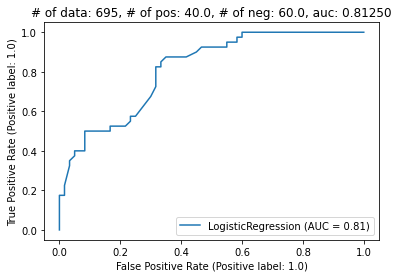

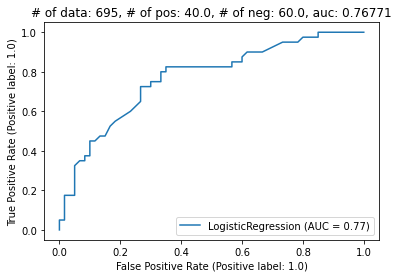

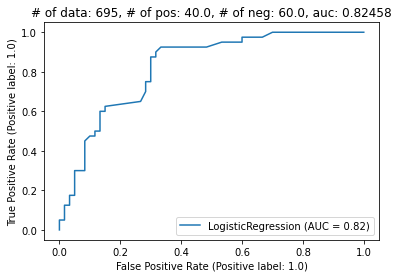

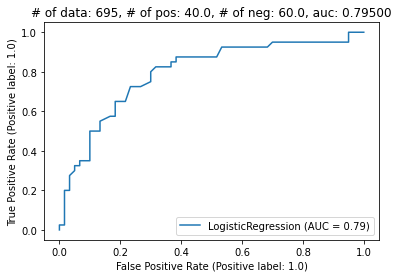

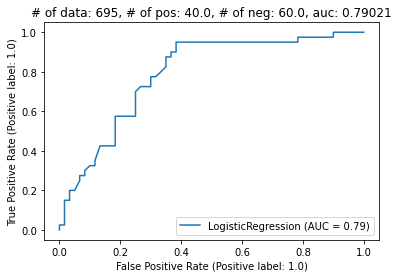

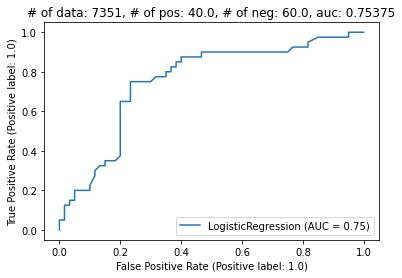

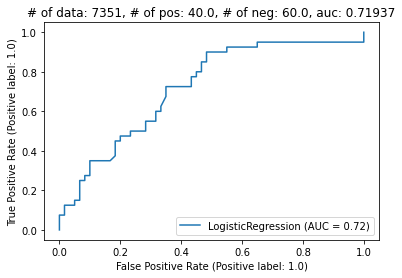

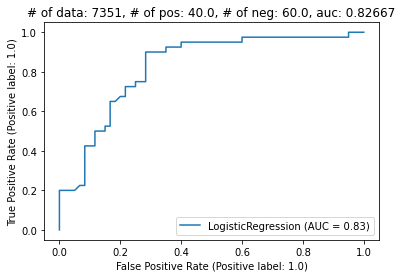

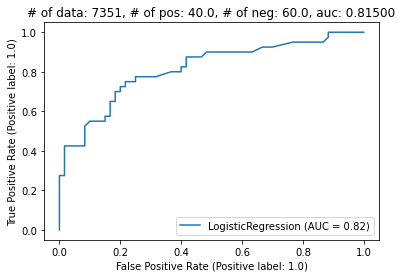

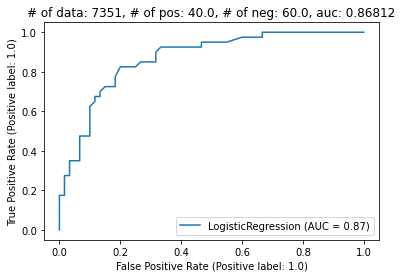

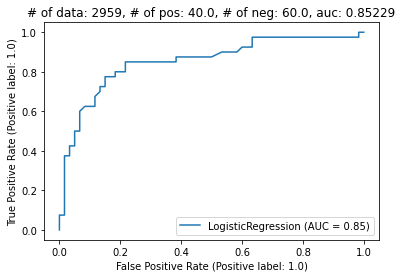

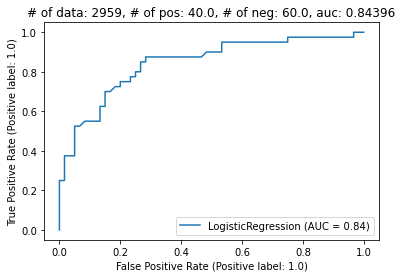

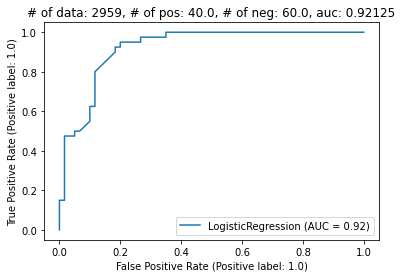

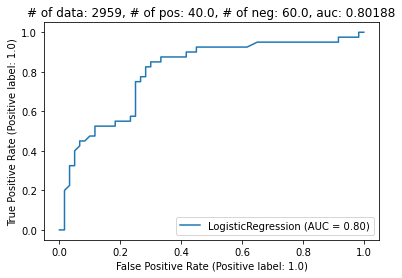

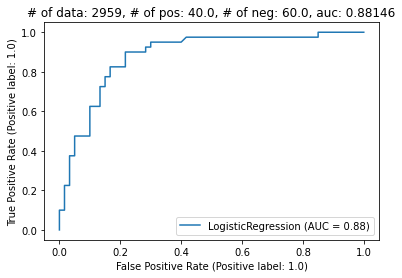

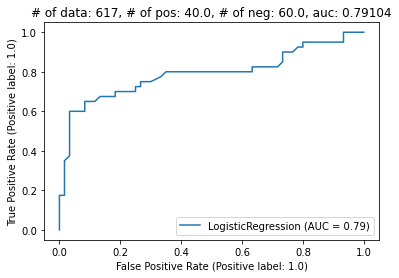

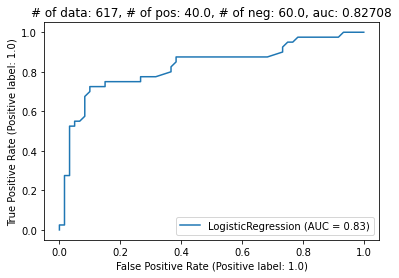

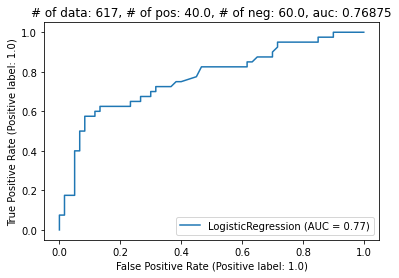

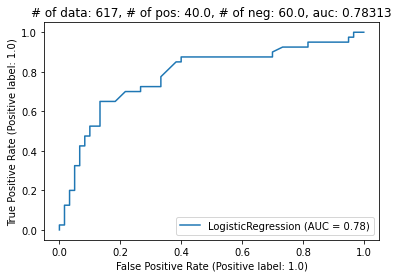

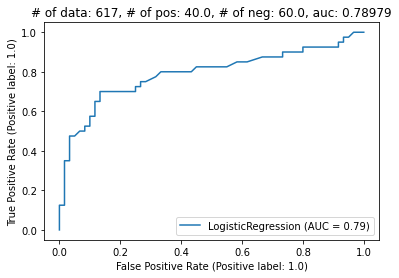

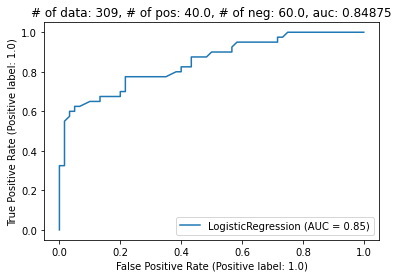

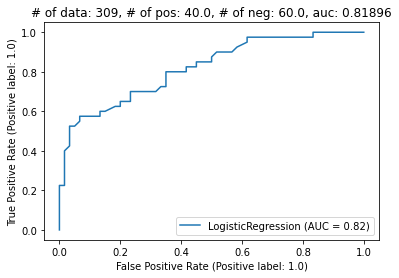

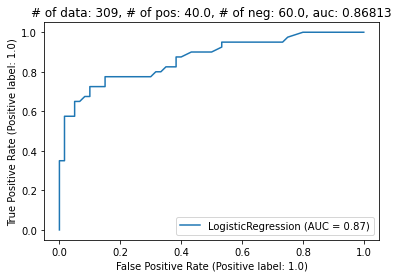

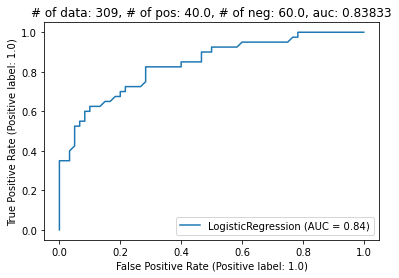

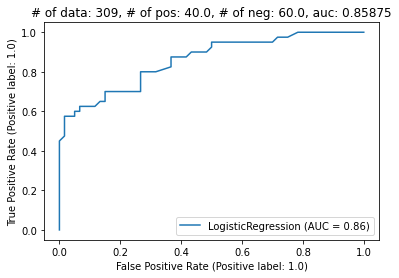

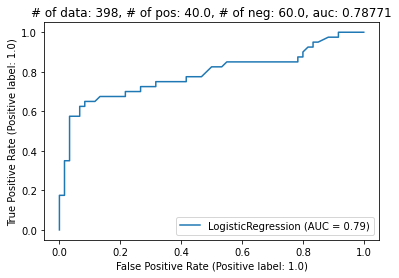

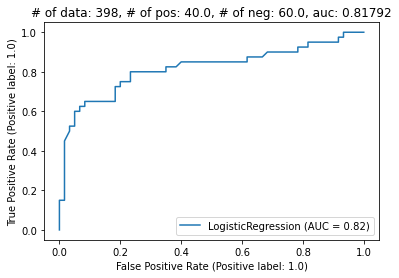

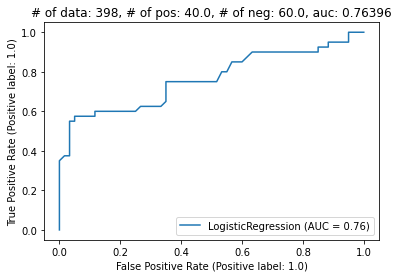

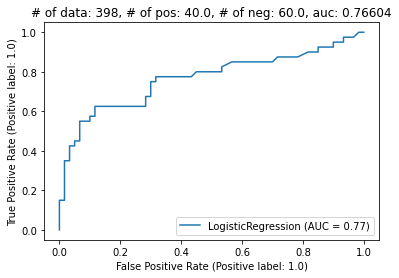

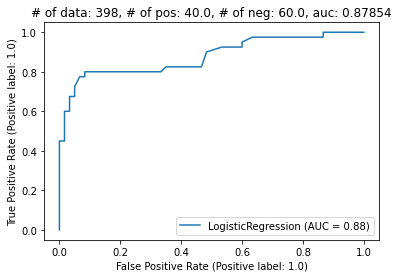

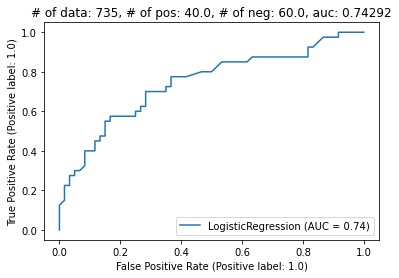

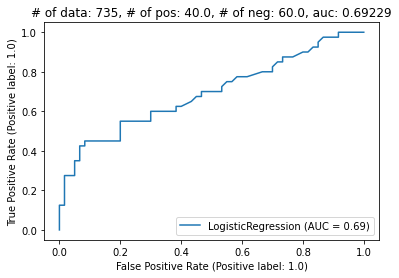

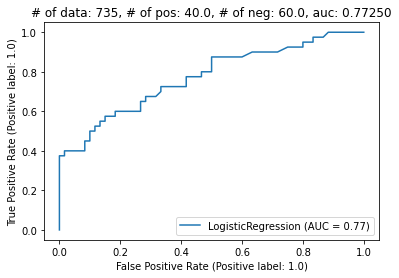

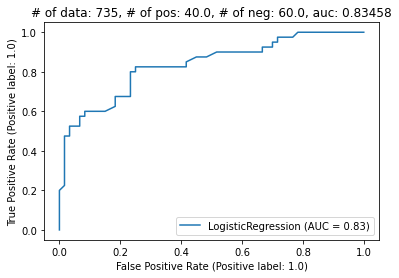

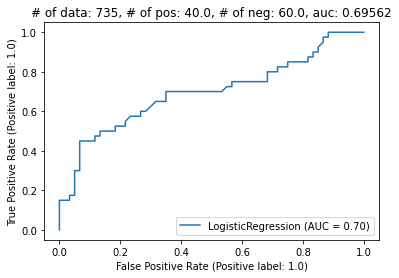

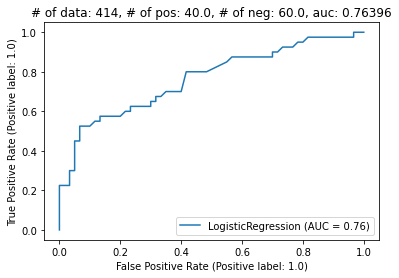

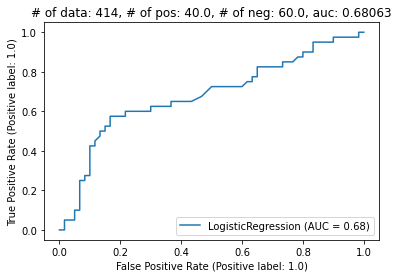

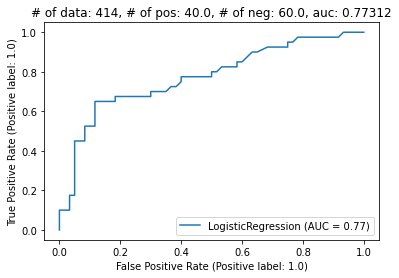

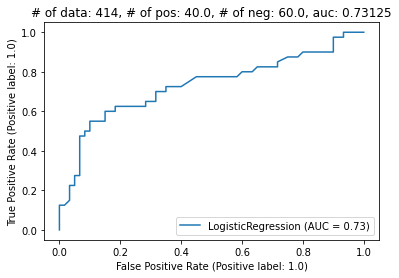

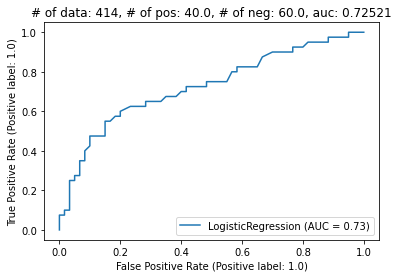

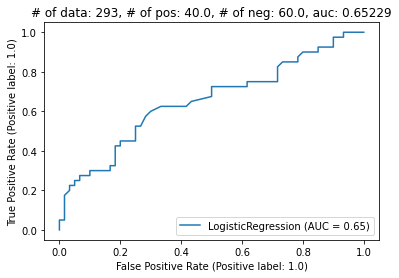

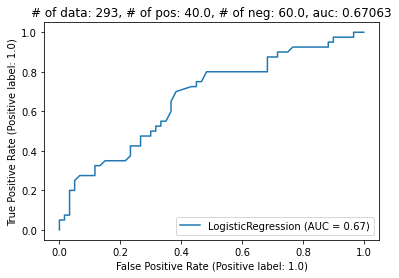

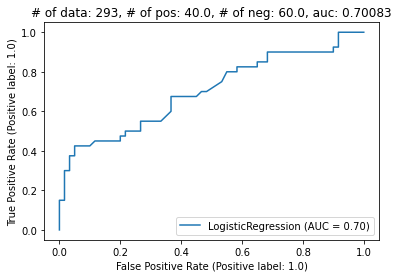

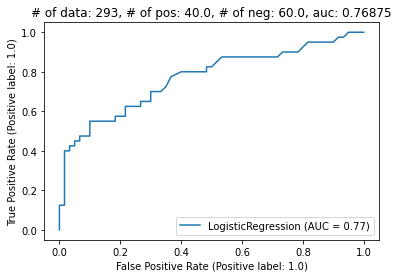

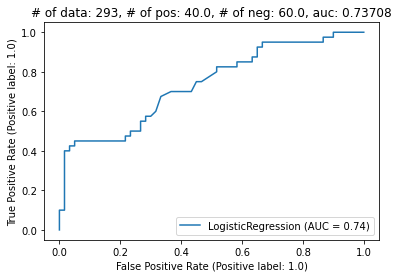

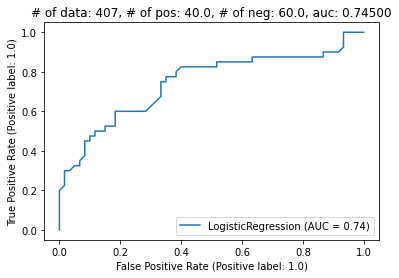

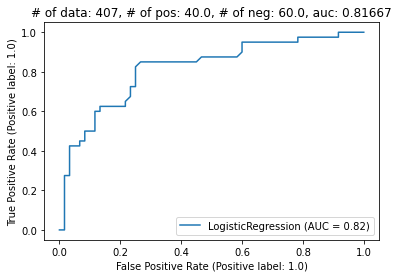

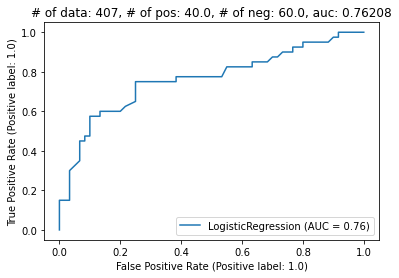

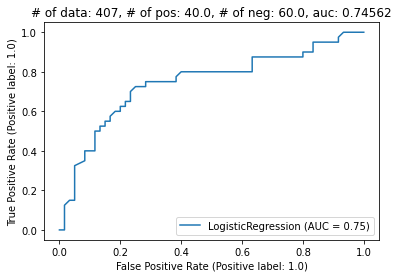

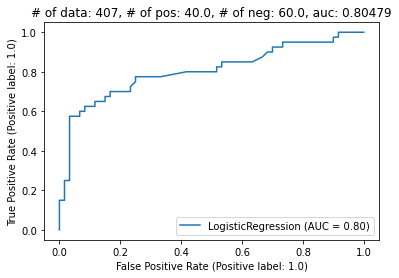

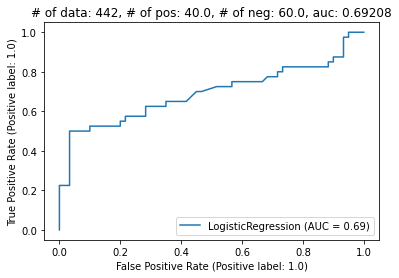

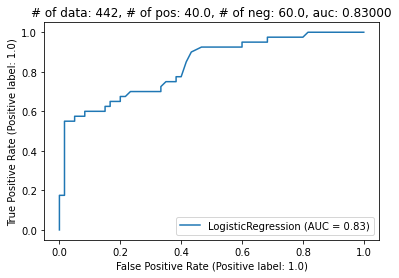

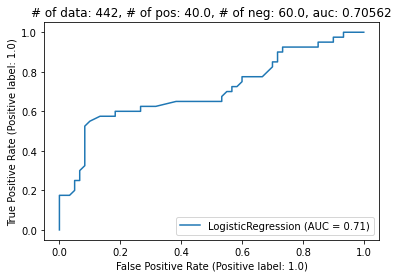

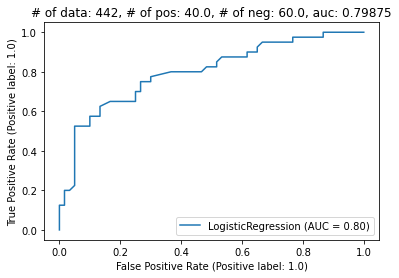

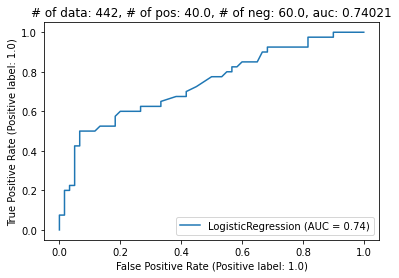

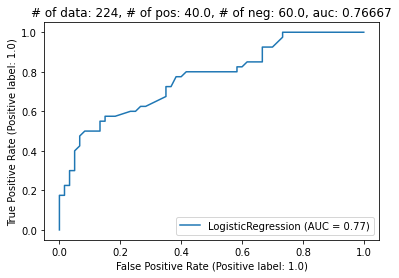

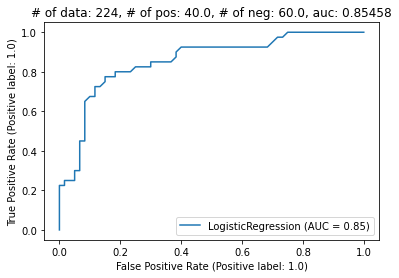

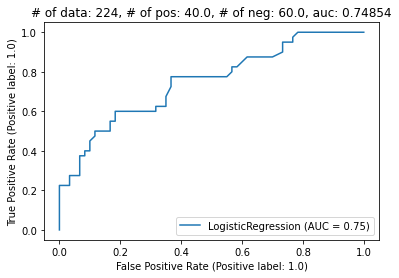

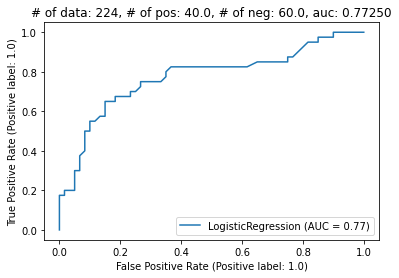

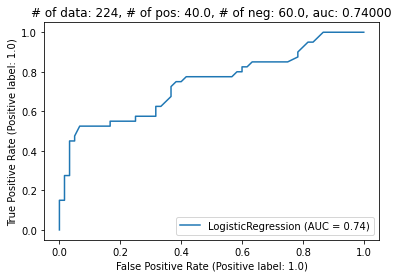

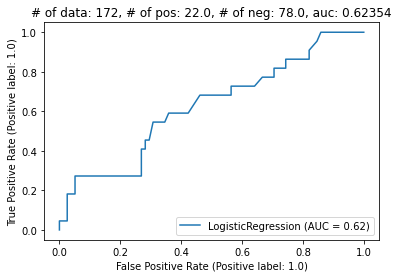

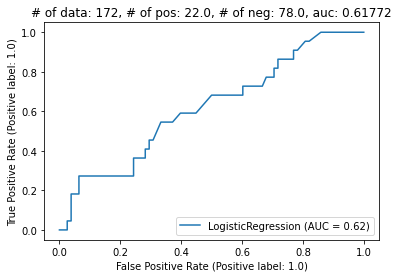

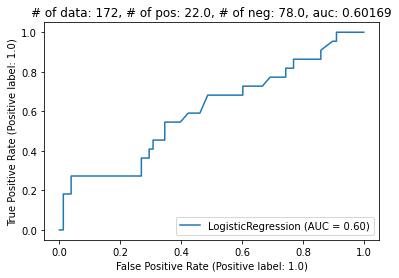

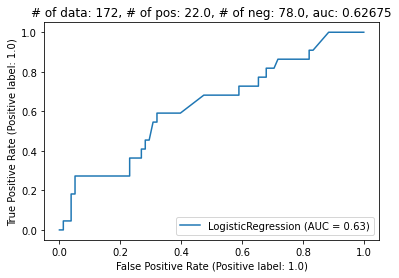

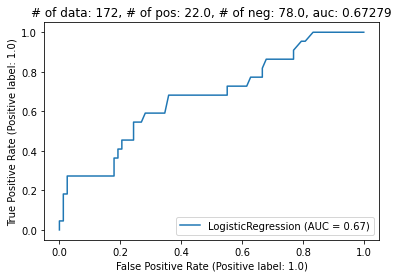

In [80]:
results = []
for year_month, size, raw_shine_test_datass in raw_shine_test_datas_list:
    print(f'date: {year_month}')
    res = {
        'date': year_month,
        'aucs': []
    }
    for raw_shine_test_datas in raw_shine_test_datass:
        shine_test_input = raw_shine_test_datas[:, :-1]
        shine_test_gt = raw_shine_test_datas[:, -1]
        auc = roc_auc_score(shine_test_gt, logistic_clf.predict_proba(shine_test_input)[:,1])
        res['aucs'].append(auc)
        sz = len(shine_test_gt)
        pos_cnt = shine_test_gt.sum()
        neg_cnt = sz - pos_cnt
        pred = logistic_clf.predict(shine_test_input)
        display_performance(logistic_clf, pred, shine_test_input, shine_test_gt, auc)
        plt.title(f'# of data: {size}, # of pos: {pos_cnt}, # of neg: {neg_cnt}, auc: {auc:.5f}')
    results.append(res)
# df_test = df_shine[input_cols]

In [81]:
for rs in results:
    aucs = np.array(rs['aucs'])
    auc1 = round(aucs[0], 4)
    auc2 = round(aucs[1], 4)
    auc3 = round(aucs[2], 4)
    auc4 = round(aucs[3], 4)
    auc5 = round(aucs[4], 4)
    date = rs['date']
#     print(round(aucs.mean(),5))
    print(f'{date} auc1:{auc1} auc2:{auc2} auc3:{auc3} auc4:{auc4} auc5:{auc5} mean:{aucs.mean():.5f}, std:{aucs.std():.5f}')

2022-02 auc1:0.8125 auc2:0.7677 auc3:0.8246 auc4:0.795 auc5:0.7902 mean:0.79800, std:0.01952
2022-03 auc1:0.7538 auc2:0.7194 auc3:0.8267 auc4:0.815 auc5:0.8681 mean:0.79658, std:0.05321
2022-04 auc1:0.8523 auc2:0.844 auc3:0.9212 auc4:0.8019 auc5:0.8815 mean:0.86017, std:0.03977
2022-05 auc1:0.791 auc2:0.8271 auc3:0.7687 auc4:0.7831 auc5:0.7898 mean:0.79196, std:0.01927
2022-06 auc1:0.8488 auc2:0.819 auc3:0.8681 auc4:0.8383 auc5:0.8588 mean:0.84658, std:0.01702
2022-07 auc1:0.7877 auc2:0.8179 auc3:0.764 auc4:0.766 auc5:0.8785 mean:0.80283, std:0.04255
2022-08 auc1:0.7429 auc2:0.6923 auc3:0.7725 auc4:0.8346 auc5:0.6956 mean:0.74758, std:0.05286
2022-09 auc1:0.764 auc2:0.6806 auc3:0.7731 auc4:0.7313 auc5:0.7252 mean:0.73483, std:0.03274
2022-10 auc1:0.6523 auc2:0.6706 auc3:0.7008 auc4:0.7687 auc5:0.7371 mean:0.70592, std:0.04258
2022-11 auc1:0.745 auc2:0.8167 auc3:0.7621 auc4:0.7456 auc5:0.8048 mean:0.77483, std:0.03018
2022-12 auc1:0.6921 auc2:0.83 auc3:0.7056 auc4:0.7988 auc5:0.7402 mea

### 100 random sampling 안하는 코드

In [82]:
# for year_month, size, raw_shine_test_datas in raw_shine_test_datas_list:
#     shine_test_input = raw_shine_test_datas[:, :-1]
#     shine_test_gt = raw_shine_test_datas[:, -1]
#     pos_cnt = shine_test_gt.sum()
#     neg_cnt = len(shine_test_gt) - pos_cnt
#     pred = logistic_clf.predict(shine_test_input)
#     display_performance(logistic_clf, pred, shine_test_input, shine_test_gt)
#     plt.title(f'date: {year_month}, # of data: {size}, # of pos: {pos_cnt}, # of neg: {neg_cnt}')
# # df_test = df_shine[input_cols]